# Model Training and Basic Optimization

<img src="https://www.mrtfuelcell.polimi.it/images/logo_poli.jpg" height="200">
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/Python_logo_and_wordmark.svg" height="150">

*Basi Fondamentali del Machine Learning*

Day 4 - 14/10/2024

Co-authors: Micheal Wood, Maciej Sakwa, Emanuele Ogliari

![Pikachu-Training](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/pikachu-training.gif?raw=true)


# Outline

1. Review machine learning project structure
2. Manually least squares regression
3. Automatic least squares regression
4. Video on neural network training
5. Train single neural network
6. Hyperparameter optimize neural network
7. Time for questions

# Learning obejctives

* Understand the necessary steps to complete a ML project
* Know how to manually fit a line to some data
* See the analogy between a simple line fit and training a neural network
* Understand the principle of error back propagation

---

# Machine Learning project structure (review)

- ML is often called a **black-box**, but it's not a *magic* black-box
- You can not solve *any* problem using *any* data
- The data and model need to be appropriate for the problem
- General project structure is repeated
  - Data changes
  - Model changes

![structure](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/project-structure.png?raw=true)

## 1. Problem definition

**Predict the Spanish electricity price at time `t` from the day-ahead price and other generation data at time `t`.**

| |  Data |
| --- | --- |
|Inputs| `price day ahead`, `generation fossil hard coal`, etc |
|Target|  `price actual` |



## 2. Data collection and engineering

Import the packages

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format # print 2 decimal places
pd.options.mode.chained_assignment = None



def import_data(filepath,drop=[]):
    df = pd.read_csv(filepath,index_col='time',).drop(columns=drop)
    df.index = pd.to_datetime(df.index,utc=True,format='ISO8601')
    df.index = df.index.tz_convert('Europe/Madrid').tz_localize(None)
    return df

We load two datasets:
1. The electricity generation in Spain
2. The weather data from 5 big cities in Spain

In [2]:
data = import_data('https://raw.githubusercontent.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/refs/heads/main/data/energy_supply.csv',drop=['generation hydro pumped storage aggregated','forecast wind offshore eday ahead'])
#data_weather = pd.read_csv('https://raw.githubusercontent.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/refs/heads/main/data/weather_features.csv')
data

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.00,329.00,0.00,4844.00,4821.00,162.00,0.00,0.00,0.00,863.00,...,49.00,196.00,0.00,6378.00,17.00,6436.00,26118.00,25385.00,50.10,65.41
2015-01-01 01:00:00,449.00,328.00,0.00,5196.00,4755.00,158.00,0.00,0.00,0.00,920.00,...,50.00,195.00,0.00,5890.00,16.00,5856.00,24934.00,24382.00,48.10,64.92
2015-01-01 02:00:00,448.00,323.00,0.00,4857.00,4581.00,157.00,0.00,0.00,0.00,1164.00,...,50.00,196.00,0.00,5461.00,8.00,5454.00,23515.00,22734.00,47.33,64.48
2015-01-01 03:00:00,438.00,254.00,0.00,4314.00,4131.00,160.00,0.00,0.00,0.00,1503.00,...,50.00,191.00,0.00,5238.00,2.00,5151.00,22642.00,21286.00,42.27,59.32
2015-01-01 04:00:00,428.00,187.00,0.00,4130.00,3840.00,156.00,0.00,0.00,0.00,1826.00,...,42.00,189.00,0.00,4935.00,9.00,4861.00,21785.00,20264.00,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,297.00,0.00,0.00,7634.00,2628.00,178.00,0.00,0.00,0.00,1.00,...,85.00,277.00,0.00,3113.00,96.00,3253.00,30619.00,30653.00,68.85,77.02
2018-12-31 20:00:00,296.00,0.00,0.00,7241.00,2566.00,174.00,0.00,0.00,0.00,1.00,...,33.00,280.00,0.00,3288.00,51.00,3353.00,29932.00,29735.00,68.40,76.16
2018-12-31 21:00:00,292.00,0.00,0.00,7025.00,2422.00,168.00,0.00,0.00,0.00,50.00,...,31.00,286.00,0.00,3503.00,36.00,3404.00,27903.00,28071.00,66.88,74.30


Summary statistics

In [3]:
data.describe() # add .T to rotate (transpose) the table if you want

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35046.00,35045.00,35046.00,35046.00,35046.00,35045.00,...,35046.00,35045.00,35046.00,35046.00,35064.00,35064.00,35064.00,35028.00,35064.00,35064.00
mean,383.51,448.06,0.00,5622.74,4256.07,298.32,0.00,0.00,0.00,475.58,...,1432.67,269.45,0.00,5464.48,1439.07,5471.22,28712.13,28696.94,49.87,57.88
std,85.35,354.57,0.00,2201.83,1961.60,52.52,0.00,0.00,0.00,792.41,...,1680.12,50.20,0.00,3213.69,1677.70,3176.31,4594.10,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,237.00,18105.00,18041.00,2.06,9.33
25%,333.00,0.00,0.00,4126.00,2527.00,263.00,0.00,0.00,0.00,0.00,...,71.00,240.00,0.00,2933.00,69.00,2979.00,24793.75,24807.75,41.49,49.35
50%,367.00,509.00,0.00,4969.00,4474.00,300.00,0.00,0.00,0.00,68.00,...,616.00,279.00,0.00,4849.00,576.00,4855.00,28906.00,28901.00,50.52,58.02
75%,433.00,757.00,0.00,6429.00,5838.75,330.00,0.00,0.00,0.00,616.00,...,2578.00,310.00,0.00,7398.00,2636.00,7353.00,32263.25,32192.00,60.53,68.01
max,592.00,999.00,0.00,20034.00,8359.00,449.00,0.00,0.00,0.00,4523.00,...,5792.00,357.00,0.00,17436.00,5836.00,17430.00,41390.00,41015.00,101.99,116.80


There's a lot of zeros in some columns, which are not useful to us. Ciao!

In [4]:
zeros_list = ['generation fossil coal-derived gas',
              'generation fossil oil shale',
              'generation fossil peat',
              'generation geothermal',
              'generation marine',
              'generation wind offshore']
nonzeros_list = [x for x in data.columns if x not in zeros_list]

data = data[nonzeros_list]

There's also lot of NaNs (not a number), which are not useful to us

In [5]:
data.isna().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


Ciao! We replace the NaNs with nearby values

In [6]:
data = data.ffill()

We can quantify the correlations by calling the .corr() function. By default, it calculates the pearsons coefficient between each column in the dataframe:

>Note that this is a measure of _linear_ relationship!

In [7]:
data.corr()['price actual'].sort_values(ascending=False).to_frame()

,price actual
price actual,1.00
price day ahead,0.73
generation fossil hard coal,0.47
generation fossil gas,0.46
total load forecast,0.44
total load actual,0.44
generation fossil brown coal/lignite,0.36
generation fossil oil,0.29
generation other renewable,0.26
generation waste,0.17


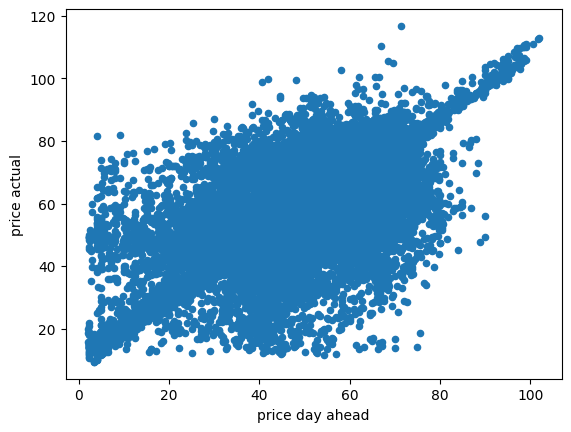

In [8]:
data.plot(x='price day ahead',y='price actual',kind='scatter');

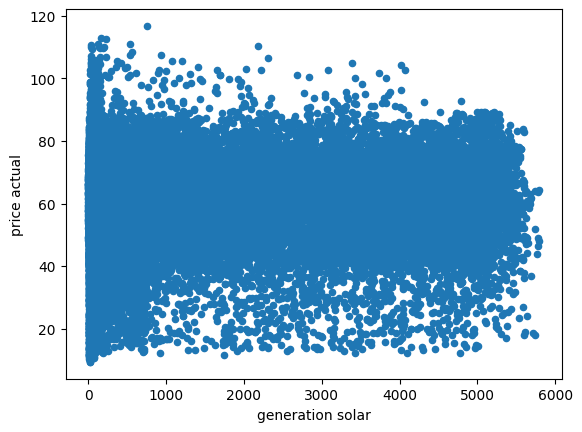

In [9]:
data.plot(x='generation solar',y='price actual',kind='scatter');

So the actual price is highly correlated positively with the day ahead price (obviously), but also with fossil fuel based generation, and total generation needed. So the more energy we need, and the more fossil fuels produce, the more expensive the energy gets.

Also it's negavitely correlated with hydro-based generation, and with wind-based generation, they are cheap sources. Surprisingly the PV-based production has low impact on the price. 

Remember in supervised learning:
- Inputs are **features**
- Outputs are what come out of the model
- What we _want_ from the model are **targets** (or labels)

In our case, we want to estimate the actual energy price using the generation data, let's extract the corresponding columns:

In [10]:
input_columns = data.columns.to_list() 
input_columns.remove('price actual')    # Inputs are all columns except for the 'price actual'

In [11]:
inputs = data[input_columns].copy()
labels = data[['price actual']].copy()

For now we don't do any modifications to the **features** we have in the dataset, let's see what results we get with almost *raw* data.

## 3. Model build and train

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

To avoid bias in fitting we **scale** the input data. The two most common methods are:

- **min-max scaling** 
- standard scaling

In [13]:
scaler = MinMaxScaler() # Set up the class instance

In [14]:
inputs_scaled = scaler.fit_transform(inputs) # Get the inputs
labels_scaled = labels.values.ravel()

Split the inputs and the labels in train and test subgroups

In [15]:
n = len(inputs) 
cutoff = int(0.7*n) # Set the cutoff threshold at 70% of the length of the input array

train_inputs = inputs_scaled[:cutoff]   # Cut before
train_labels = labels_scaled[:cutoff]   # Cut before

test_inputs = inputs_scaled[cutoff:]    # Cut after
test_labels = labels_scaled[cutoff:]    # Cut after

Visually:

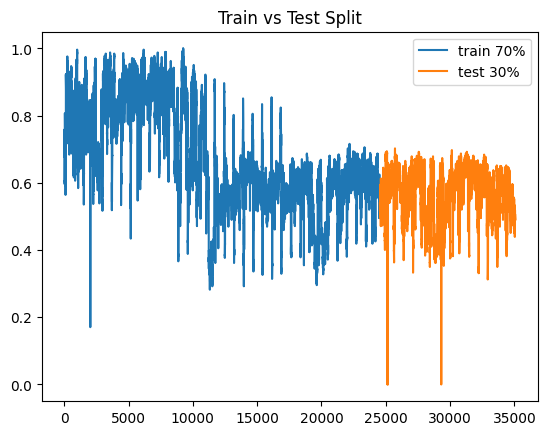

In [16]:
plt.plot(np.arange(0, cutoff), train_inputs[:, 0],label='train 70%')
plt.plot(np.arange(cutoff, n), test_inputs[:, 0],label='test 30%')
plt.legend()
plt.title('Train vs Test Split')
plt.show()

Create empty model:

In [17]:
model = LinearRegression()

Train (`fit`) the model to estimate the labels given the inputs:

In [18]:
model.fit(X=train_inputs, y=train_labels)

LinearRegression()

Finally, we can call the `.predict()` method with test inputs to see how the model performs with unseen data:

In [19]:
results = model.predict(test_inputs)

We can quickly visualise the results with a plot (we can declare it in a function to quickly reuse it later):

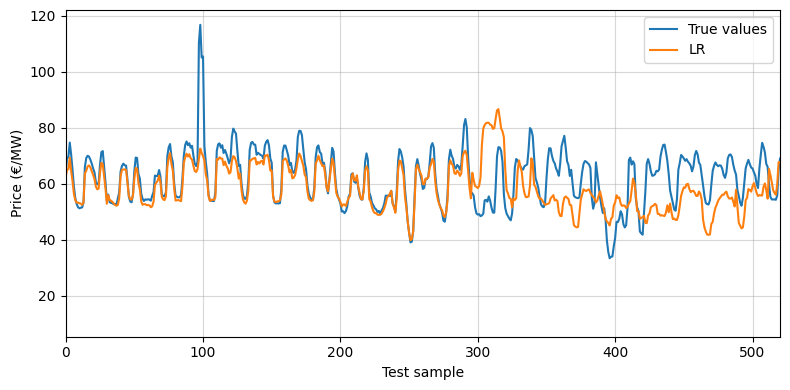

In [20]:
def plot_results(results:np.array, model_name:str, x_range=(0, 520)) -> None:   
    plt.figure(figsize=(8, 4))

    # Plots
    plt.plot(test_labels, label='True values')
    plt.plot(results, label=model_name)

    # Visuals
    plt.xlim(x_range)
    plt.xlabel('Test sample')
    plt.ylabel('Price (€/MW)')
    plt.grid(which='major', alpha = 0.5)

    # Tidy up
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_results(results, 'LR')

## 4. Evaluate results

We want to evaluate the model(s) using metrics that help us make a decision.

First, for notation:
- $y_{true}$ are the true values (`test_labels` in our case)
- $y_{pred}$ are the predicted values

Two common mean-type (average) metrics in regression problems are:

* mean absolute error: $ MAE = |y_{true}-y_{pred}| $ 
* mean squared error: $ MSE = |(y_{true}-y_{pred})^2| $ 

We can also take the square root of $MSE$ so that we come back to the original units (e.g. kW):
* root mean square error: $ RMSE = \sqrt{MSE}$

Let's define a function that takes the results and the labels and outputs the metrics:

In [21]:
def print_results(model, results, labels):
    
    # Calculate the metrics using the labels and the results
    mae = (labels-results).__abs__().mean()
    mse = ((labels-results)**2).mean()
    rmse = np.sqrt(mse)
    mape = (mae / labels).mean()
    
    # Print out the results
    print(f'Results for model {model}: \n- MAE:\t{mae:.02f}\n- MSE:\t{mse:.02f}\n- RMSE:\t{rmse:.02f}\n- MAPE:\t{mape*100:.02f}%')

Now let's see the results:

In [22]:
print_results(model=model, results=results, labels=test_labels)

Results for model LinearRegression(): 
- MAE:	5.93
- MSE:	87.96
- RMSE:	9.38
- MAPE:	9.94%


---
# Training: Linear Regression

Today we focus on training.

We sometimes say fitting for more simple linear models.

## Regression "by hand"

Earlier we saw `price day ahead` and `price actual` correlated well (0.79).

Indeed, they look similar.

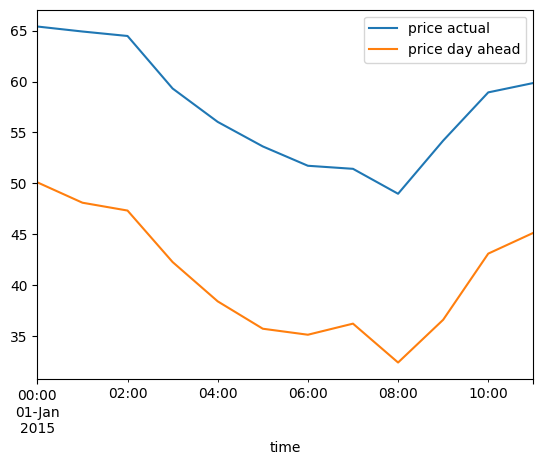

In [23]:
data[['price actual','price day ahead']][:12].plot();

Let's look again at the scatter plot to see the correlation

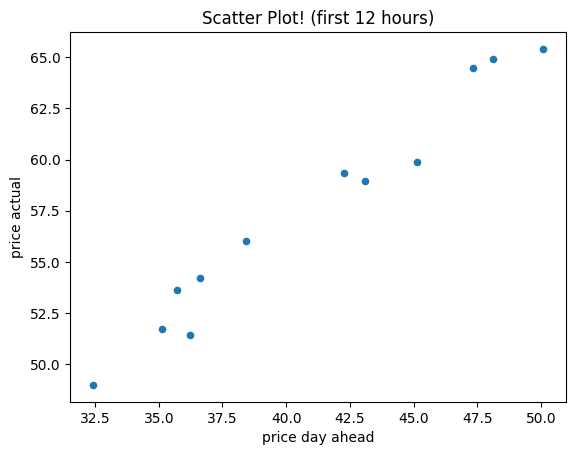

In [24]:
data[:12].plot(x='price day ahead',
               y='price actual',
               kind='scatter',
               title='Scatter Plot! (first 12 hours)');

In [25]:
def plot_scatter_line(df,
                      x='price day ahead',
                      y='price actual',
                      yline='price actual regression',
                      w=None,
                      b=None,
                      show_errors=False,
                      limit=12):
    df = df[:limit].sort_values(x).copy()

    f = df.plot(x=x,y=y,kind='scatter',label='data',title=f'Scatter Plot (first {limit} h)',xlabel=x+' (x)',ylabel=y+' (y)')  
    if w is not None:
        df[yline] = w*df[x] + b
    if yline in df.columns:
        f.plot(df[x],df[yline],color='red',label='line fit',linestyle='--')    
        f.title.set_text(f'Scatter Plot with Line Fit')
    if show_errors:
        label=None
        for i,(_x,_y,_yp) in enumerate(zip(df[x],df[y],df[yline])):
            if i == len(df[x])-1:
                label = 'errors'
            f.plot([_x, _x], [_y, _yp], color='green', linestyle='-', linewidth=1,label=label,)
        mse = ((df[y]-df[yline])**2).mean()
        f.title.set_text(f'Mean of squared errors: {mse:.2f}')
    f.legend()
    
#plot_scatter_line(data)

Now, taking the data..

In [26]:
data[['price day ahead','price actual']][:12]

,price day ahead,price actual
time,,
2015-01-01 00:00:00,50.10,65.41
2015-01-01 01:00:00,48.10,64.92
2015-01-01 02:00:00,47.33,64.48
2015-01-01 03:00:00,42.27,59.32
2015-01-01 04:00:00,38.41,56.04
2015-01-01 05:00:00,35.72,53.63
2015-01-01 06:00:00,35.13,51.73
2015-01-01 07:00:00,36.22,51.43
2015-01-01 08:00:00,32.40,48.98


... build and "fit" model `y=w*x+b` where

- `x` is `price day ahead` (input)

- `y` is `price actual` (label)

- `w` and `b` are your choice

Start with the last row of data:

In [27]:
# w*(x) + b
1.1*(45.14) + 10.2

59.854

Here we "fit" the model on just one data point.

And we can "test" on the other ones:

In [28]:
1.1*(43.10) + 10.2

57.61

In [29]:
1.1*(36.6) + 10.2

50.46000000000001

Faster this way:

In [30]:
data['price actual regression'] = 1.1*data['price day ahead'] + 10.2
data[['price day ahead','price actual','price actual regression']][:12]

,price day ahead,price actual,price actual regression
time,,,
2015-01-01 00:00:00,50.10,65.41,65.31
2015-01-01 01:00:00,48.10,64.92,63.11
2015-01-01 02:00:00,47.33,64.48,62.26
2015-01-01 03:00:00,42.27,59.32,56.70
2015-01-01 04:00:00,38.41,56.04,52.45
2015-01-01 05:00:00,35.72,53.63,49.49
2015-01-01 06:00:00,35.13,51.73,48.84
2015-01-01 07:00:00,36.22,51.43,50.04
2015-01-01 08:00:00,32.40,48.98,45.84


Let's see it!

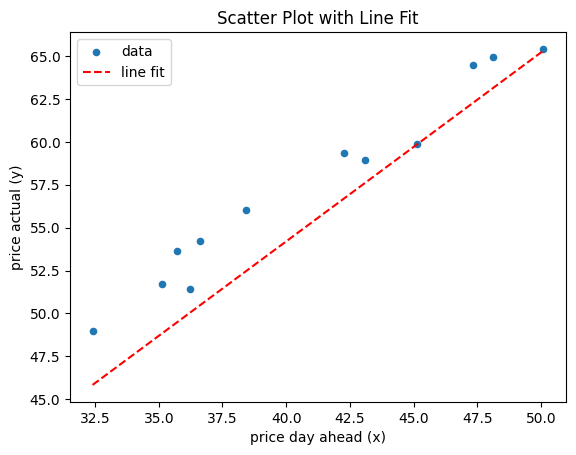

In [31]:
plot_scatter_line(data)

Not bad, but we can do better

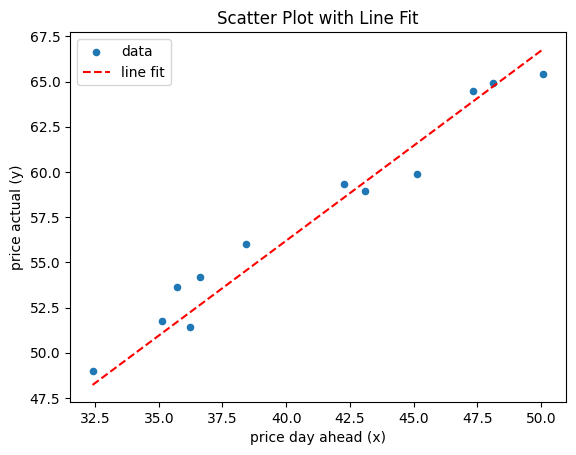

In [32]:
data['price actual regression'] = 1.05*data['price day ahead'] + 14.2

plot_scatter_line(data)

Question, can we quantify the "fit"?

The vertical distances from the data to the line are the errors, or **residuals.**

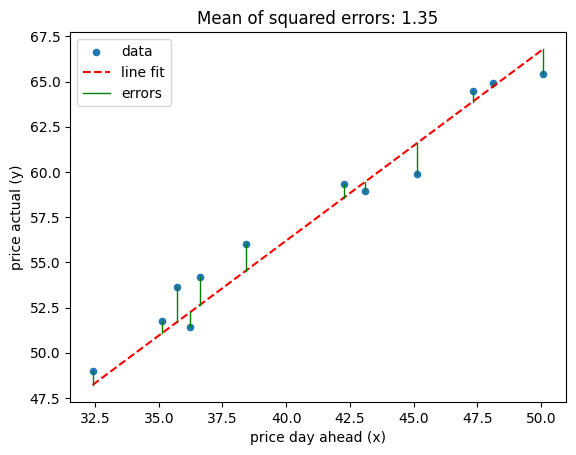

In [33]:
plot_scatter_line(data,show_errors=True)

## Least squares

We always want less total error.

Mathematically, we want to *minimize* the *sum* of errors.

But, do you prefer the errors of model A or B?

| Model | Errors | Sum |
| --- | --- | --- |
| A | -10, 10 | 0 |
| B | -1, 1| 0 |

Probably B. Why? Because the sum of the _absolute value_ of errors is smaller.

| Model | Errors | \|Errors\| | Sum of Absolute Value of Errors |
| --- | --- | --- | --- |
| A | -10, 10 | 10,10 | 20 |
| B | -1, 1| 1,1 | 2 |

Squaring a number is a kind of absolute value, and is faster for your computer.

| Model | Errors | Sum of Squared Errors |
| --- | --- | --- |
| A | -10, 10 | 200 |
| B | -1, 1| 2 |

Lasty we prefer the mean, so we can compare for different numbers of data points.

| Model | Errors | Mean of Squared Errors |
| --- | --- | --- |
| A | -10, 10 | 100 |
| B | -1, 1| 1 |
| C | -1, 1, -1, -1, 1| 1 |

Let's visualize it.

In the image below:

- The red line is fit to the yellow dot data
  - Each red square is the _square of the error_ for each dot
- The blue line is not fit
  - Each blue square is the _square of the error_ for each dot

**The sum of the red square areas is less than the sum of the blue squares areas.**

The red line has the **least squares**.

If the sum is less, so is the mean.

![interactive-regression](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/interactive-regression.png?raw=true)

Here's the interactive version: [Least Squares Regression](https://phet.colorado.edu/sims/html/least-squares-regression/latest/least-squares-regression_all.html)

## Regression by ML

That was a lot of work! Machine learning is much faster.

Remember the steps:

1) Problem definition (unchanged)

2) Data collect and engineer

In [34]:
x = data[['price day ahead']][:12]
y = data['price actual'][:12]

3) Model build and train

In [35]:
# y = w*x + b
model = LinearRegression()
model.fit(x, y)

print('w =',model.coef_[0])
print('b =',model.intercept_)

w = 0.9403175521345777
b = 18.97461952724558


4) Evaluate results

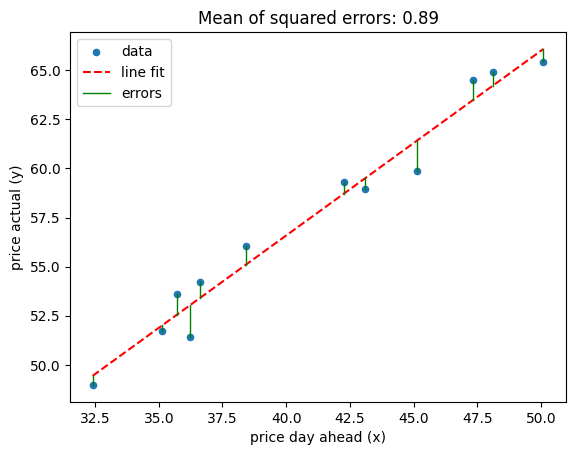

In [36]:
data['price actual regression'] = data['price day ahead']*model.coef_[0] + model.intercept_
plot_scatter_line(data,show_errors=True)

So far we are doing fitting and predicting on the same, first 12 hours of data.

What about the next 12 hours? 

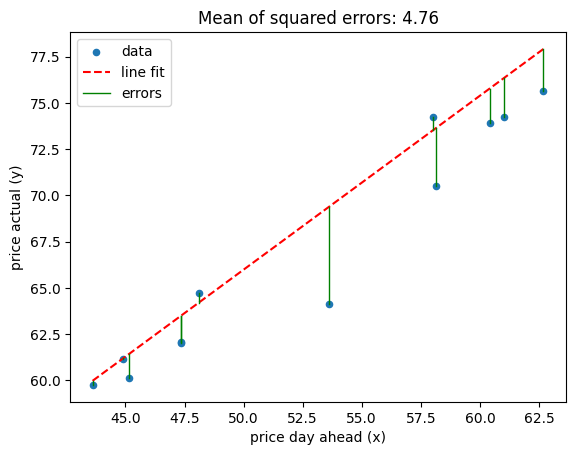

In [37]:
plot_scatter_line(data[12:24],show_errors=True)

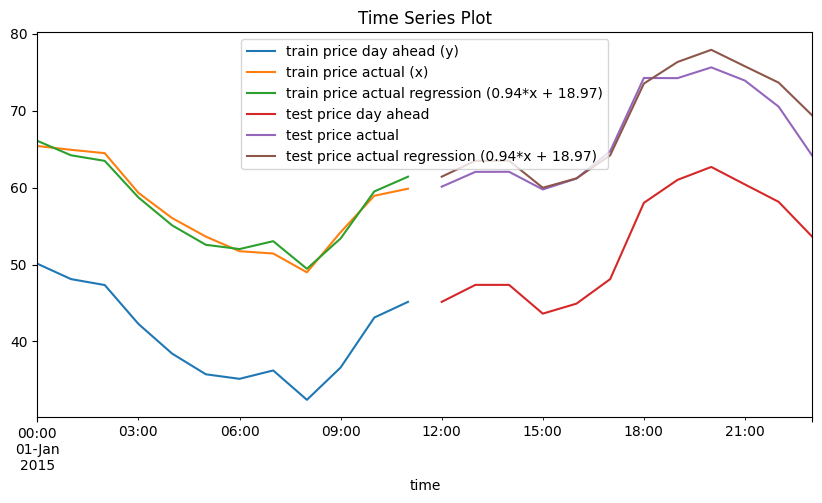

In [38]:
def plot_timeseries(df,
                    x='price day ahead',
                    y='price actual',
                    yhat='price actual regression',
                    w=None,
                    b=None,
                    test_split = None,
                    limit=24):    
    df = df[[x,y,yhat]][:limit].copy()
    
    if test_split is not None:
        train = pd.DataFrame({x:df[x].values[:test_split],
                              y:df[y].values[:test_split],
                              yhat:df[yhat].values[:test_split],},
                            index=df.index[:test_split])
        test = pd.DataFrame({'test '+x:df[x].values[test_split:],
                        'test '+y:df[y].values[test_split:],
                        'test '+yhat:df[yhat].values[test_split:]},
                   index=df.index[test_split:])
        f = pd.concat((train,test),axis=1).plot(figsize=(10,5))
        if w is not None:
            yhat = yhat+f' ({w:.2f}*x + {b:.2f})'
        legend = ['train '+x+' (y)','train '+y+' (x)','train '+yhat,'test '+x,'test '+y,'test '+yhat]
    else:
        f = df.plot(figsize=(10,5))
        if w is not None:
            yhat = yhat+f' ({w:.2f}*x + {b:.2f})'
        legend = [x,y,yhat]
    f.title.set_text('Time Series Plot')
    

    f.legend(legend)

plot_timeseries(data,w=model.coef_[0],b=model.intercept_,test_split=12)

### More data

In [39]:
x = data[['price day ahead']][:48]
y = data['price actual'][:48]

In [40]:
# y = w*x + b
model = LinearRegression()
model.fit(x, y)

print('w =',model.coef_[0])
print('b =',model.intercept_)

w = 0.07363456403386417
b = 63.40983720046266


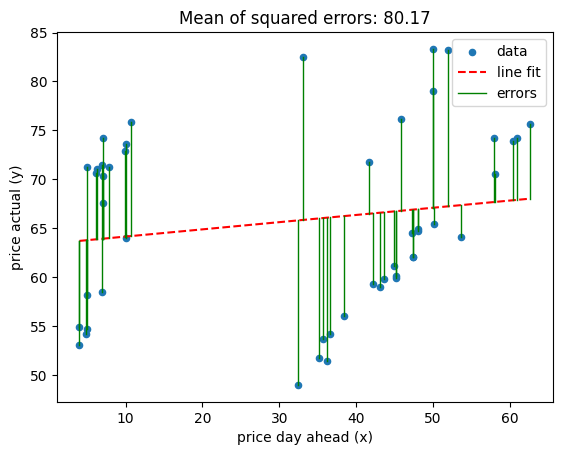

In [41]:
data['price actual regression'] = data['price day ahead']*model.coef_[0] + model.intercept_
plot_scatter_line(data,show_errors=True,limit=48)

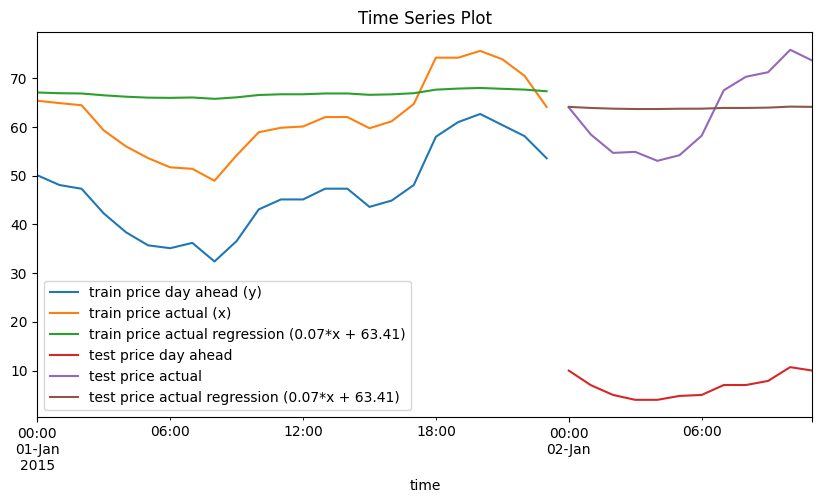

In [42]:
plot_timeseries(data,w=model.coef_[0],b=model.intercept_,test_split=24,limit=36)

## Regression in 3D

So far everything is 2-dimensional:

| | Dimension | Data |
| --- | --- | --- |
|Input| `x` | `price day ahead` |
|Target| `y` | `price actual` |

That's boring. Let's add a third dimension:

| | Dimension | Data |
| --- | --- | --- |
|Input| `x1` | `price day ahead` |
|Input| `x2` | `generation fossil hard coal` |
|Target| `y` | `price actual` |

In [43]:
data[['price day ahead','generation fossil hard coal','price actual']][:12]

,price day ahead,generation fossil hard coal,price actual
time,,,
2015-01-01 00:00:00,50.10,4821.00,65.41
2015-01-01 01:00:00,48.10,4755.00,64.92
2015-01-01 02:00:00,47.33,4581.00,64.48
2015-01-01 03:00:00,42.27,4131.00,59.32
2015-01-01 04:00:00,38.41,3840.00,56.04
2015-01-01 05:00:00,35.72,3590.00,53.63
2015-01-01 06:00:00,35.13,3368.00,51.73
2015-01-01 07:00:00,36.22,3208.00,51.43
2015-01-01 08:00:00,32.40,3335.00,48.98


In [44]:
def plot_scatter_plane_3d(df,
                          x='price day ahead',
                          y='generation fossil hard coal',
                          z='price actual',
                          yplane='plane fit',
                          limit=12):
    import plotly.graph_objects as go
    from sklearn.linear_model import LinearRegression


    fig = go.Figure(data=[go.Scatter3d(
        x=df[x][:limit],
        y=df[y][:limit],
        z=df[z][:limit],
        mode='markers',
        name='data',
        marker=dict(
            size=5,
            color='red',
            opacity=0.8 )   )])
    
    X = df[[x, y]][:limit]
    Z = df[z][:limit]
    
    model = LinearRegression()
    model.fit(X, Z)
    
    xx, yy = np.meshgrid(np.linspace(X[x].min(), X[x].max(), 10), np.linspace(X[y].min(), X[y].max(), 10))
    zz = model.intercept_ + model.coef_[0] * xx + model.coef_[1] * yy
    
    fig.add_trace(go.Surface(
        x=xx,
        y=yy,
        z=zz,
        colorscale='Viridis',
        opacity=0.5,
        name='plane fit',
    ))    

    fig.update_layout(
        scene=dict(xaxis_title=x,yaxis_title=y,zaxis_title=z),
        title=f'Scatter 3D Plot (first {limit} h)')

    # Show plot
    fig.show()
    
plot_scatter_plane_3d(data)

The plane is the line fit, but in 3D instead of 2D.

Two thought experiments:

1) 3D to 2D
- Rotate the plot so `generation fossil hard coal` goes _into_ the screen
- You are seeing just the 2D correlation _without_ coal
- Or rotate the plot so `price day ahead` goes _into_ the screen
- You are seeing just the 2D correlation _with_ coal

2) 2D to 3D
- Go back up to one of the 2D plots above
- Pretend there is a third axis going _into_ the screen
- That axis is `generation fossil hard coal`

---
# Training: Neural Network

Shockingly, a neural network is just a lot of fitting `w`'s and `b`'s to data.

- Note the activation function, sigmoid (σ) here

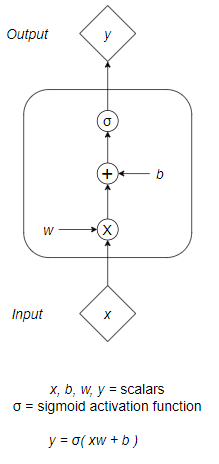



But the neural network usually doesn't make a line, or a plane.

Instead, with all the many `w` and `b` parameters we say the a **hyperplane** is made.

Note its not flat: the activiation function makes neurons **non-linear**.

<img src="https://i.pinimg.com/originals/0c/e9/07/0ce90753f7605cc0b26c0e96597ae9e2.gif" width=600>

How do we choose the right `w`s and `b`s to minimize mean squared error?

It's an optimizaion problem. And we use a combination of two methods:
- **gradient descent**
- **backpropagation of errors**

`![gradient-descent](https://i.pinimg.com/originals/0c/e9/07/0ce90753f7605cc0b26c0e96597ae9e2.gif)`


<img src="https://robodk.com/blog/wp-content/uploads/2023/11/NeuralNetwork-Training.gif" width=600>

Excellent video explanation: [3 Brown 1 Blue - What is Backpropagation Really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U)

## Regression by Small MLP

Mean Squared Error (train): 0.8377066191160575
Mean Squared Error: (test) 2.0412211695160543
Weights: [array([[2.89961463]]), array([[6.03426891]])]
Biases: [array([7.34457063]), array([4.6722946])]
Number of iterations: 11062
Loss: 0.48096401678015255
Best loss: 0.48096401678015255
Number of layers: 3
Number of outputs: 1


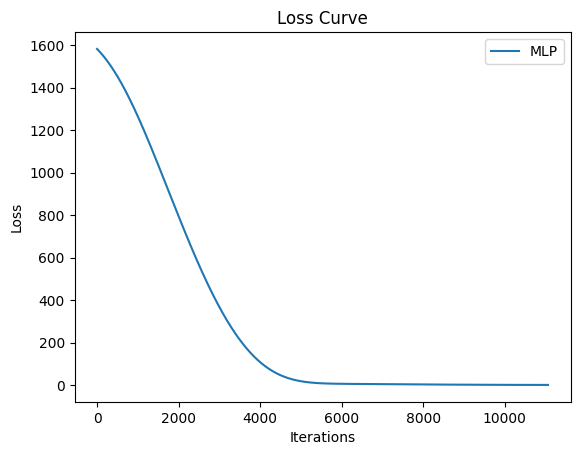

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and target
data = data.sort_index()
X = data[['price day ahead']][:24].copy()
y = data['price actual'][:24].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(1,),
                   max_iter=100000,
                   random_state=42,
                   #early_stopping=True,
                   #validation_fraction=0.1,
                   #verbose=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

train = y_train.to_frame()
train['price day ahead'] = X_train
train['price mlp fit'] = y_fit

test = y_test.to_frame()
test['price day ahead'] = X_test
test['price mlp fit'] = y_pred

print("Mean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Loss Curve',ylabel='Loss',xlabel='Iterations');

In [46]:
def plot_scatter_mlp(df,
                      x='price day ahead',
                      y='price actual',
                      ymlp='price mlp fit',
                      show_errors=False,
                      limit=12):
    df = df[:limit].sort_values(x).copy()

    f = df.plot(x=x,y=y,kind='scatter',label='data',title=f'Scatter Plot (first {limit} h)',xlabel=x+' (x)',ylabel=y+' (y)')  
    if ymlp in df.columns:
        f.plot(df[x],df[ymlp],label='mlp fit',color='red',)    
        f.title.set_text(f'Scatter Plot with MLP Fit')
    if show_errors:
        label=None
        for i,(_x,_y,_yp) in enumerate(zip(df[x],df[y],df[ymlp])):
            if i == len(df[x])-1:
                label = 'errors'
            f.plot([_x, _x], [_y, _yp], color='green', linestyle='-', linewidth=1,label=label,)
        mse = ((df[y]-df[ymlp])**2).mean()
        f.title.set_text(f'Mean of squared errors: {mse:.2f}')
    f.legend()

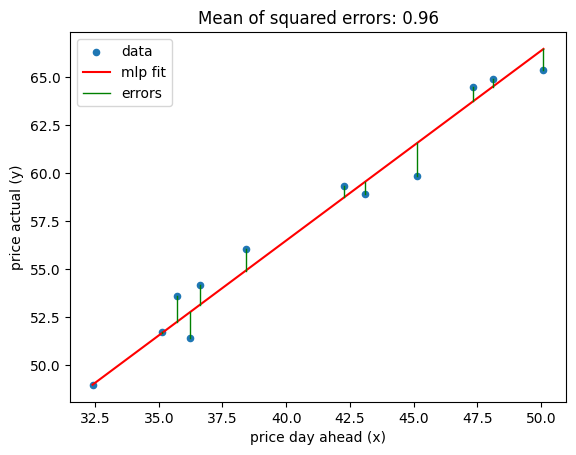

In [47]:
plot_scatter_mlp(train,limit=12,show_errors=True)

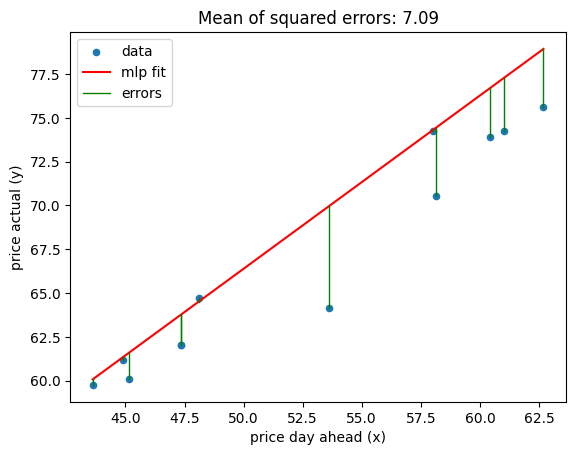

In [48]:
plot_scatter_mlp(test,limit=12,show_errors=True)

## For real, now

Weights: [array([[-2.03642018e-06,  7.37805905e-01,  9.94780448e-02,
         1.87241706e-02,  3.23357517e-01, -1.53173033e-02,
        -3.86008436e-02,  4.94508126e-01,  5.81539361e-10,
         8.28080456e-04, -4.96851670e-02,  1.95674395e-01,
         6.22780447e-01,  3.22506820e-01, -1.89437525e-01,
         3.35219495e-01,  3.61617337e-01, -1.85045366e-13,
         4.22762098e-01,  3.93223775e-01,  5.10869462e-01,
         1.73044137e-01, -8.21299126e-04, -5.97261482e-06,
        -9.20309217e-13,  5.84731024e-01, -2.09546401e-01,
         4.49115222e-01, -1.61126987e-09, -2.19516866e-01,
         4.22124200e-02, -1.27098079e-02, -3.66564890e-02,
         1.48161083e-01,  6.62117563e-01,  6.56563369e-01,
         4.13948461e-01,  3.11811734e-01,  7.62401262e-02,
         4.10696482e-01,  3.53160120e-01,  2.11701331e-14,
        -4.54886737e-02,  6.69069748e-01, -2.38045004e-03,
         8.09535744e-05,  3.78838083e-01,  4.56496826e-01,
         1.07899151e-12, -1.03825028e-02,  6.7

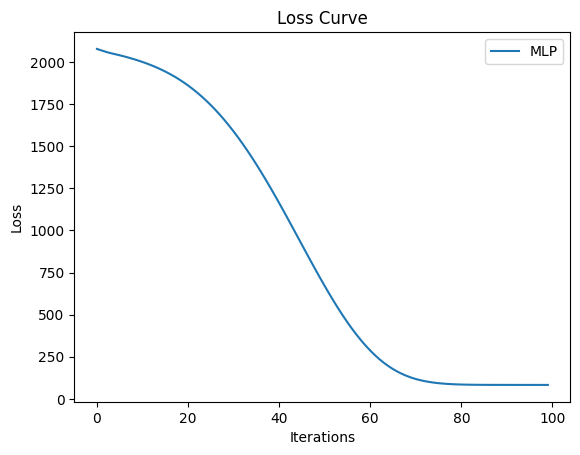

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and target
data = data.sort_index()
X = data[['price day ahead']][:1000].copy()
y = data['price actual'][:1000].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,12),
                   max_iter=100000,
                   random_state=42,
                   early_stopping=True,
                   validation_fraction=0.1,
                   #verbose=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

train = y_train.to_frame()
train['price day ahead'] = X_train
train['price mlp fit'] = y_fit

test = y_test.to_frame()
test['price day ahead'] = X_test
test['price mlp fit'] = y_pred

print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Loss Curve',ylabel='Loss',xlabel='Iterations');

## More inputs

Weights: [array([[ 5.36728427e-01,  1.91244092e-01, -3.60522044e-21,
         4.22587194e-01,  2.57418266e-01, -4.47409959e-10,
        -4.27858728e-07,  5.69514777e-01,  1.61706158e-38,
         5.00728509e-24,  2.47135178e-01,  6.25091498e-01,
         5.50053926e-01, -3.05566296e-13,  2.37595087e-01,
        -2.11601816e-11, -1.04163429e-01,  4.07980182e-01,
         3.88168988e-01,  2.82929609e-01,  4.42777839e-01,
        -1.18981774e+00, -4.06837725e-24, -4.94093009e-35,
         1.87695662e-42,  1.98539344e-13,  2.89024152e-01,
         4.26351413e-01,  4.80698037e-01,  2.23988370e-01,
        -4.52839975e-02, -9.74227983e-11,  3.00258694e-01,
         1.28439393e+00,  6.17448057e-01,  5.41100931e-01,
        -4.55264056e-26, -4.57967837e-08,  5.23751941e-01,
        -5.89665194e-02,  1.80495449e-01,  3.93444677e-01,
         1.79328826e-01,  6.55144685e-01, -2.88708407e-18,
         4.92225301e-01, -2.59772969e-28,  4.37270241e-01,
         5.03866516e-01,  3.06406847e-01,  6.8

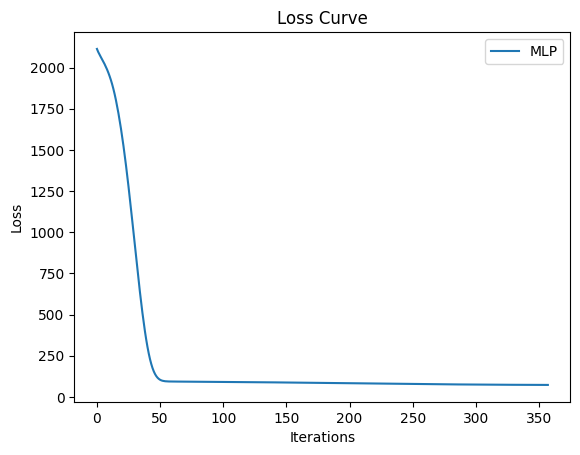

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and target
data = data.sort_index()
X = data[['price day ahead','generation fossil hard coal']][:1000].copy()
y = data['price actual'][:1000].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,12),
                   max_iter=100000,
                   random_state=42,
                   early_stopping=True,
                   validation_fraction=0.1,
                   #verbose=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()


train = pd.DataFrame(X_train,columns=['price day ahead','generation fossil hard coal'],
                     index=y_train.index)
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test,columns=['price day ahead','generation fossil hard coal'],
                     index=y_test.index)
test['price mlp fit'] = y_pred

print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Loss Curve',ylabel='Loss',xlabel='Iterations');

## Everything

Weights: [array([[ 2.40859571e-001,  1.40552897e-316,  1.10455122e-001, ...,
         4.11751119e-287, -2.05941124e-001, -1.82878781e-001],
       [-3.75205126e-002,  8.05820574e-318, -7.67898234e-002, ...,
        -1.48963845e-277,  2.69212371e-001,  1.99147779e-001],
       [ 2.80248102e-001, -4.42661524e-317, -2.29445473e-001, ...,
         3.05902486e-253,  1.11975254e-002, -2.47747379e-001],
       ...,
       [ 4.48762434e-001,  1.73818144e-316,  1.04413612e-001, ...,
         1.26319229e-243,  1.08287602e-001,  5.12042270e-002],
       [ 8.97077926e-001, -1.46384675e-316,  2.27364927e-001, ...,
         8.77269311e-249,  6.95928666e-002,  2.74276373e-001],
       [ 7.34389435e-001,  1.97059649e-316,  4.09438736e-001, ...,
         8.80644857e-249, -6.38116325e-002,  4.99786455e-002]]), array([[ 6.64739821e-001, -3.53606254e-002, -4.08645945e-317, ...,
         5.09594129e-317,  3.51045458e-001,  3.68718624e-001],
       [ 3.35113018e-317,  2.31540762e-316, -7.73915346e-317, ...,

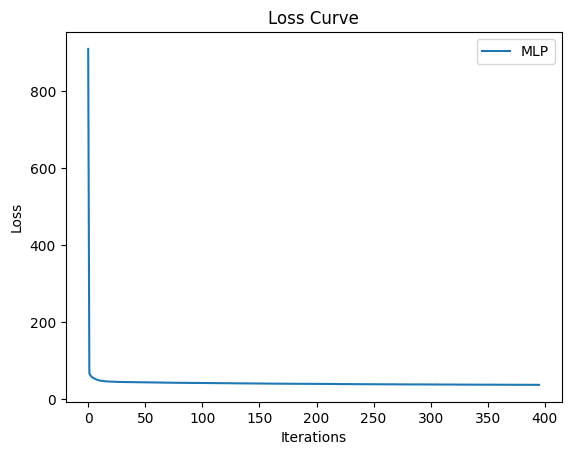

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and target
data = data.sort_index()
cols = data.columns.to_list()
cols.remove('price actual')
X = data[cols].copy()
y = data['price actual'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,12),
                   max_iter=100000,
                   random_state=42,
                   early_stopping=True,
                   validation_fraction=0.1,
                   #verbose=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()


train = pd.DataFrame(X_train,columns=cols,
                     index=y_train.index)
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test,columns=cols,
                     index=y_test.index)
test['price mlp fit'] = y_pred

print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Loss Curve',ylabel='Loss',xlabel='Iterations');